In [1]:
import numpy as np
import pandas as pd

import joblib
import os
import random
import shutil
import sys

from collections import defaultdict
from scipy.special import log_ndtr, logsumexp
from scipy.interpolate import Akima1DInterpolator

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics

from tensorboard.backend.event_processing import event_accumulator

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities.data_downloader import train_val_test_downloader
from utilities.upsampling import upsampling
from utilities.extracted_features_explorer import explorer
from utilities.plots import plt, COLORMAP, visualize_latent

In [4]:
from warnings import simplefilter, filterwarnings
simplefilter("ignore", category=RuntimeWarning)
filterwarnings("ignore", ".*does not have many workers.*")
filterwarnings("ignore", ".*exists and is not empty.*")
filterwarnings("ignore", ".*sampler has shuffling enabled.*")

In [5]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)
L.seed_everything(42)

Seed set to 42


42

# Description

Here we present **AutoEncoder** Model based on 1D Convolutional layers. A number of possible architectures are trained and logged. The experiments with various architectures are hard-coded.

## Fitting
The loss function is:

$${\rm Loss} = \Bigg\langle \left[\frac{\log_{10}({\rm rate}/{\rm s}^{-1})_{\rm reco} - \log_{10}({\rm rate}/{\rm s}^{-1})_{\rm true}}{\log_{10}({\rm rate}/{\rm s}^{-1})~{\rm err.}}\right]^2\Bigg\rangle_{\rm non-empty~bins}\quad +\quad\delta \cdot\Bigg\langle\Big|{ \Delta}_t \log_{10}({\rm rate}/{\rm s}^{-1})_{\rm reco}\Big|\Bigg\rangle_{\rm all~bins}$$

The first term corresponds to weighted MSE, and the second one applies L1-regularization to a predicted timeseries. 

## Scoring procedure
We infer the anomalous score from the weighted reconstruction error distribution.

We fit the cumulative distribution function of the weighted reconstruction error decimal logarithm $\lg[{\rm wre}]$ using our custom Kernel Density Estimation procedure (which should be rather called Kernel Cumulative Distribution Estimation):

$${\rm CDF}(\lg[{\rm wre}]) = \Bigg\langle \int\limits_{-\infty}^{\lg[{\rm wre}]} \frac{d\xi}{b\sqrt{2\pi}} \exp\Big[-\frac{(\xi - \lg[{\rm wre}_i])^2}{2b^2}\Big]\Bigg\rangle_i = \Bigg\langle \int\limits_{-\infty}^{\frac{\lg[{\rm wre}] - \lg[{\rm wre}_i]}{b}} \frac{d\zeta}{\sqrt{2\pi}} \exp\Big[-\frac{1}{2}\zeta^2\Big]\Bigg\rangle_i$$

Bandwidth $b$ is defined by Silverman's rule of thumb, see [[reference]](https://archive.org/details/densityestimatio00silv_0/page/44/mode/2up).

We then define $p$-value as $1-{\rm CDF}$ and score samples accordingly.

# Dataset
We use linearly interpolated rebinned dataset. In order to enlarge testing set, we upsample it applying gaussian noise and random shift augmentation.

In [8]:
train, val, test, labels = train_val_test_downloader('interp_flares')

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [9]:
train_upsampled = upsampling(train)
print(f'Upsampled training fragment length: {len(train_upsampled)}')

Upsampled training fragment length: 81000


In [10]:
class LightCurveDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame,
                 data_col:str='lgRate',
                 weight_col:str='weight'):
        
        data = np.array(dataframe.loc[:, data_col].tolist(),
                        dtype=np.float32)
        weight = np.array(dataframe.loc[:, weight_col].tolist(),
                          dtype=np.float32)
        
        self.data = torch.from_numpy(
            data).unsqueeze(dim=1)   # value
        self.weight = torch.from_numpy(
            weight).unsqueeze(dim=1) # weight

        # using dataframe index = event names 
        # as labels
        labels = dataframe.index
        self.label_enc = LabelEncoder()
        self.labels = torch.as_tensor(self.label_enc.fit_transform(labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.weight[idx]

In [11]:
train_dataset, val_dataset, test_dataset = (
    LightCurveDataset(train_upsampled),
    LightCurveDataset(val),
    LightCurveDataset(test)
)

In [12]:
train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(val_dataset,
                        batch_size=256,
                        shuffle=False,
                        num_workers=0)
test_loader = DataLoader(test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=0)

# for predictions on non-augmented train:
train_loader_ = DataLoader(LightCurveDataset(train),
                           batch_size=256,
                           shuffle=False,
                           num_workers=0)

# Model
**AutoEncoder** Model based on the following block structure: 1D Convolutional layer + BatchNormalization + LeakyReLU activation.
The number of channels growth trend is 2^(depth of the layer), the starting number of channels and the depth are architetural parameters.

## Torch Models

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dim:int,
                 architecture:tuple=(32, 4),
                 tseries_length:int=64):
        super().__init__()

        self.hidden_dims = [
            architecture[0]* 2**pow for pow in range(architecture[1])
            ]                                       # num of filters in layers
        self.tseries_length = tseries_length

        modules = []
        in_channels = 1                             # initial num of channels
        for h_dim in self.hidden_dims:              # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=in_channels,    # num of input channels
                        out_channels=h_dim,         # num of output channels
                        kernel_size=3,
                        stride=2,                   # convolution kernel step
                        padding=1,                  # save shape
                    ),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim                     # changing num of 
                                                    # input channels for 
                                                    # next iteration

        modules.append(nn.Flatten())                # to vector
        intermediate_dim = (
            self.hidden_dims[-1] * 
            self.tseries_length // (2**len(self.hidden_dims))
        )
        modules.append(nn.Linear(in_features=intermediate_dim,
                                 out_features=latent_dim))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim:int,
                 architecture:tuple=(32, 4),
                 tseries_length:int=64):
        super().__init__()
        self.hidden_dims = [
            architecture[0]* 2**pow for pow in range(architecture[1]-1, 0, -1)
            ]                                       # num of filters in layers
        self.tseries_length = tseries_length

        intermediate_dim = (
            self.hidden_dims[0] * 
            self.tseries_length // (2**len(self.hidden_dims))
        )
        self.linear = nn.Linear(in_features=latent_dim,
                                out_features=intermediate_dim)

        modules = []
        for i in range(len(self.hidden_dims) - 1):  # define upsample layers
            modules.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv1d(
                        in_channels=self.hidden_dims[i],
                        out_channels=self.hidden_dims[i + 1],
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.BatchNorm1d(self.hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv1d(in_channels=self.hidden_dims[-1],
                          out_channels=1,
                          kernel_size=3, padding=1)
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)        # from latents space to Linear
        x = x.view(
            -1, self.hidden_dims[0],
            self.tseries_length // (2**len(self.hidden_dims))
            )                     # reshape
        x = self.decoder(x)       # reconstruction
        return x

# For Variational AE, not used here
# =================================
class VAEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0:   # check for the parity of the latent space
            raise Exception('Latent size for VAEncoder must be even')

        super().__init__(latent_dim)
# =================================

## Lightning wrapper

In [14]:
class LitAE(L.LightningModule):
    def __init__(self, encoder, decoder, derivative_weight=2.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.derivative_weight = derivative_weight

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

    def forward_handler(self, data,
                        *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)
        return latent, recon

    def loss_handler(self, recon, data, weight, latent,
                     *args, **kwargs):
        # here is the loss function computing
        recon_loss = torch.masked_select(
            input = F.mse_loss(
                recon, data, reduction='none'
            ) * weight,
            mask = weight.ge(0.0)
        )
        recon_loss = recon_loss.mean()

        # derivative penalty = 
        # L1-regularization of the output timeseries
        derivative_loss = torch.abs(
            torch.diff(recon, n=2, dim=-1)
        ).mean()

        # total loss
        loss = recon_loss + self.derivative_weight * derivative_loss

        return loss

    def training_step(self, batch, batch_idx):
        data, labels, weight = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, weight, latent)

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels, weight = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, weight, latent)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_start(self):
        # create dict with empty tensors for further accumulating over batches
        self.test_result = defaultdict(torch.Tensor)

    def test_step(self, batch, batch_idx):
        data, labels, weight = batch

        latent, recon = self.forward_handler(data, labels)
        self.update_test_result(data, weight, recon, latent, labels)

    def update_test_result(self, data, weight, recon, latent, labels):
        # accumulating results every batch
        self.test_result['real'] = torch.cat(
            [self.test_result['real'], data.cpu()]
        )
        self.test_result['weight'] = torch.cat(
            [self.test_result['weight'], weight.cpu()]
        )
        self.test_result['recon'] = torch.cat(
            [self.test_result['recon'], recon.cpu()]
        )
        self.test_result['latent'] = torch.cat(
            [self.test_result['latent'], latent.cpu()]
        )
        self.test_result['labels'] = torch.cat(
            [self.test_result['labels'], labels.cpu()]
        )

    def on_test_epoch_end(self):
        # simply change type from torch tensor to numpy array
        # for every item in test_result dictionary
        for key in self.test_result:
            self.test_result[key] = self.test_result[key].numpy()

In [13]:
# For Variational AE, not used here
# =================================
class LitVAE(LitAE):
    def __init__(self, encoder, decoder,
                 derivative_weight=1.0,
                 kld_weight=0.005,
                 ):
        super().__init__(encoder, decoder, derivative_weight)
        self.kld_weight = kld_weight

    def vae_split(self, latent):
        size = (
            latent.shape[1] // 2
        )  # divide the latent representation into mu and log_var
        mu = latent[:, :size]
        log_var = latent[:, size:]
        return mu, log_var

    def vae_reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn(mu.shape[0], mu.shape[1]).to(self.device)
        return eps * sigma + mu

    def kld_loss(self, mu, log_var):
        var = log_var.exp()
        kl_loss = torch.mean(
            -0.5 * torch.sum(log_var - var - mu**2 + 1, dim=1), dim=0
        )
        return kl_loss

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample)
        return latent, recon

    def loss_handler(self, recon, data, weight, latent, *args, **kwargs):
        mu, log_var = self.vae_split(latent)
        # here is the loss function computing
        loss = torch.masked_select(
            input = F.mse_loss(recon, data, reduction='none') * weight,
            mask = weight.ge(0.0)).mean() + self.derivative_weight * torch.abs(
            torch.diff(recon, dim=-1)
            ).mean() + self.kld_weight * self.kld_loss(mu, log_var)
        return loss
# =================================

# Utilities

#### Training loop utilities

In [17]:
def create_models(latent_dim:int=3, architecture:tuple=(32, 4)):
    """
    Creates autoencoder model instance
    """
    encoder, decoder = (
        Encoder(latent_dim=latent_dim, architecture=architecture),
        Decoder(latent_dim=latent_dim, architecture=architecture)
    )
    autoencoder = LitAE(encoder, decoder)
    exp_name = f'AE_dim={latent_dim}_archi=' + '%d_%d' % architecture + '_copy'
    
    os.mkdir('./lightning_logs/'+exp_name)
    return encoder, decoder, autoencoder, exp_name

In [18]:
def save_latest_model(exp_name:str, target_dir:str):
    """
    Saves the latest verison of the trained model
    together with data collected during training loop
    
    Please note that target_dir, if exists,
    will be completely overwritten!
    """
    logdir = f'./lightning_logs/{exp_name}'
    available_versions = sorted([
        '/'+ver for ver in
        os.listdir(logdir)
        if ver.startswith('version')
    ])
    latest = logdir + available_versions[-1]
    
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.mkdir(target_dir)
        
    shutil.copytree(latest, target_dir, dirs_exist_ok=True)
    shutil.copyfile(logdir+'/best.ckpt', target_dir+'/best.ckpt')
    print(f'model logged at {target_dir}')

#### Learning curve visualization

In [19]:
def extract(event_acc_instance:event_accumulator.EventAccumulator, tag:str='train_loss'):
    """
    Extracts info from EventAccumulator instance
    """
    steps = []
    values = []
    for event in event_acc_instance.Scalars(tag):
        steps.append(event.step)
        values.append(event.value)
    return steps, values

def plot_learning_curve(target_dir:str, show:bool=True,
                        cut:int=2, freq:int=10):
    """
    Plots learning curve for train- and val- loss
    """
    
    event_files = [file for file in os.listdir(target_dir) if 'events.out.tfevents' in file]
    num_files = len(event_files)
    print(f'Found {num_files} file(s)')
    if num_files > 0:
        event_file = event_files[-1]
        print(f'Processing {event_file}')
        event_file_path = os.path.join(target_dir, event_file)
        event_acc = event_accumulator.EventAccumulator(event_file_path)
        event_acc.Reload()
    else:
        return False
    
    steps_train, values_train = extract(event_acc, 'train_loss')
    steps_valid, values_valid = extract(event_acc, 'val_loss')
    steps_epoch, values_epoch = extract(event_acc, 'epoch')
    
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    ticks_epoch, labels_epoch = (
        [float(step) for step in steps_epoch[::cut]][::freq], 
        [str(int(el)) for el in values_epoch[::cut]][::freq]
    )
    plt.xticks(ticks_epoch, labels=labels_epoch)
    
    min_loss = np.floor(np.min(values_train + values_valid))
    plt.ylim(1, 3)
    
    plt.grid(True)
    
    plt.errorbar(steps_train, values_train, color='gray', label='train', marker='s', markersize=4)
    plt.errorbar(steps_valid, values_valid, color='xkcd:blue', label='val', marker='s', markersize=4)
    plt.axvline(steps_valid[::-1][np.argmin(values_valid[::-1]).item()],
                0, (np.min(values_valid)-1)/2,
                color='xkcd:blue', linestyle='dashed')
    plt.text(steps_valid[::-1][np.argmin(values_valid[::-1]).item()]*1.05, min_loss + 0.1,
             'best', color='black')
    
    plt.legend(loc='upper right')
    
    if not os.path.isdir(f'{target_dir}/Figures'):
        os.mkdir(f'{target_dir}/Figures')
        
    plt.savefig(f'{target_dir}/Figures/learning_curve.pdf',
               format='pdf', bbox_inches='tight')
    if show:
        plt.gcf().set_dpi(300)
        plt.show()
    else:
        plt.close()

#### Predictions

In [20]:
# For Variational AE, not used here
# =================================
def reparametrize_latent(vae, latent):
    mu, log_var = vae.vae_split(latent)
    var = np.exp(log_var)

    mu, log_var = torch.tensor(mu), torch.tensor(log_var)
    sample = vae.vae_reparametrize(mu, log_var).numpy()
    return sample
# =================================

In [21]:
def get_dict_result(trainer, model, dataloader, ckpt_path):
    
    with torch.no_grad():
        trainer.test(model, dataloader, ckpt_path=ckpt_path)
    model.test_result[
        'labels'
    ]=dataloader.dataset.label_enc.inverse_transform(
    model.test_result[
        'labels'
        ].astype(int)
    )

    real = model.test_result['real'].squeeze()
    recon = model.test_result['recon'].squeeze()
    weight = model.test_result['weight'].squeeze()


    weightedMSE = (real-recon)**2 * weight
    pred_errors = (weightedMSE ** 0.5).tolist()

    weightedMSE = np.ma.masked_array(data=weightedMSE,
                                     mask=~(weight.astype(bool))
    )
    weightedMSE = weightedMSE.mean(axis=1, keepdims=True)

    latent = model.test_result['latent'].copy()
    
    # For Variational AE, not used here
    # =================================
    if hasattr(model, 'vae_reparametrize') and callable(model.vae_reparametrize):
        # for VAE, we must reparametrize latent first
        latent = reparametrize_latent(model, latent)
    # =================================
    
    latentdim = latent.shape[-1]

    latent = pd.DataFrame(
        data=np.concatenate((latent, weightedMSE), axis=1),
        index=model.test_result['labels'],
        columns=['feature_'+str(dim) for dim in range(latentdim)]+['wMSE'])

    latent.insert(loc=latentdim+1, column='pred_error', value=pred_errors)

    return latent, real, recon, weight

In [32]:
def get_predictions(trainer:L.Trainer, AE:LitAE):
    """
    Creates predictions of a trained AutoEncoder
    
    Returns
    -------
    scoring : Akima1DInterpolator (callable)
        A function that takes decimal logarithm of the 
        weighted reconstruction MSE and returns ln of p-value
        
    df : pd.DataFrame
        The resulting scored dataframe
    """
    
    # predictions for the augmented training dataset
    train_upsampled_latent, real, recon, weight = get_dict_result(
        trainer, AE, train_loader, 'best')
    
    log10wMSE = np.log10(train_upsampled_latent['wMSE'].values).ravel()
    # define scoring function using log10[weightedMSE_train] 
    # and custom KDE (since sklearn KernelDensity calculates 
    # log-likelihood but not p-value)
    
    n_samples = log10wMSE.size
    SilvermanRuleBandwidth = (4/3/n_samples)**(1/5) * np.std(log10wMSE)

    logcdf = lambda x: logsumexp(
        log_ndtr(
            (x-log10wMSE)/SilvermanRuleBandwidth
        ), axis=0, b=1/n_samples
    ).item()
    
    logpvalue = lambda x: logsumexp(
        [0.0, logcdf(x)], b=[1.0, -1.0]
    )
    scoring = np.vectorize(logpvalue)
    
    log10_wMSE_grid = np.linspace(-3, 3, 10000)
    log_pvalue_grid = scoring(log10_wMSE_grid)
    
    scoring = Akima1DInterpolator(log10_wMSE_grid, log_pvalue_grid)
    scoring.extrapolate=True
    
    # predictions for the non-augmented dataset
    train_latent, real, recon, weight = get_dict_result(
        trainer, AE, train_loader_, 'best')
    val_latent, real, recon, weight = get_dict_result(
        trainer, AE, val_loader, 'best')
    
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
    tbins = np.linspace(1, 7, 65)
    t = (tbins[1:] + tbins[:-1])/2
    for i in range(25):
        m = weight[i].astype(bool)
        x, y, yerr = t[m], real[i, m], weight[i, m]**(-1/2)
        ax[i // 5][i % 5].set_xlim(1, 8)
        ax[i // 5][i % 5].set_ylim(-4, 4)
        ax[i // 5][i % 5].errorbar(x, y-3.0, yerr, fmt="s", color="black")
        ax[i // 5][i % 5].plot(t, recon[i]-3.0, linewidth=2, color="dimgray")
    plt.gcf().set_dpi(300)
    plt.show()
    
    test_latent, real, recon, weight = get_dict_result(
        trainer, AE, test_loader, 'best')
    
    df = pd.concat(
        (train_latent, val_latent, test_latent),
        axis=0, ignore_index=False
    )
    df['sample'] = (
        ['train'] * len(train_latent) +
        ['val'] * len(val_latent) +
        ['test'] * len(test_latent)
    )
    df['score'] = df['wMSE'].apply(lambda x: np.clip(scoring(np.log10(x)), None, 0.0))
    df['p-value'] = df['score'].apply(np.exp)
    
    return scoring, df

# Training Models & Get Predictions

In [ ]:
!rm -rf lightning_logs/AE_dim=3_archi=32_4_copy

## *«Standard»* Architecture (32, 4)

In [23]:
encoder, decoder, autoencoder, exp_name = create_models(
    latent_dim=3, architecture=(32, 4))
exp_name

'AE_dim=3_archi=32_4_copy'

In [24]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', mode='min', min_delta=0, patience=20)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'./lightning_logs/{exp_name}',
    filename='best', monitor='val_loss', mode='min')

logger = TensorBoardLogger(save_dir='./lightning_logs', name=exp_name)

trainer = L.Trainer(max_epochs=500, logger=logger,
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    enable_progress_bar=False
                   )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


#### Training loop

In [25]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/{exp_name} --port 6011

In [26]:
trainer.fit(autoencoder, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 133 K  | train
1 | decoder | Decoder | 131 K  | train
--------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


In [27]:
save_latest_model(exp_name, f'./Architectures/{exp_name}')

model logged at ./Architectures/AE_dim=3_archi=32_4_copy


Found 1 file(s)
Processing events.out.tfevents.1732981838.MacBook-Air-Nickolay.local.79406.0


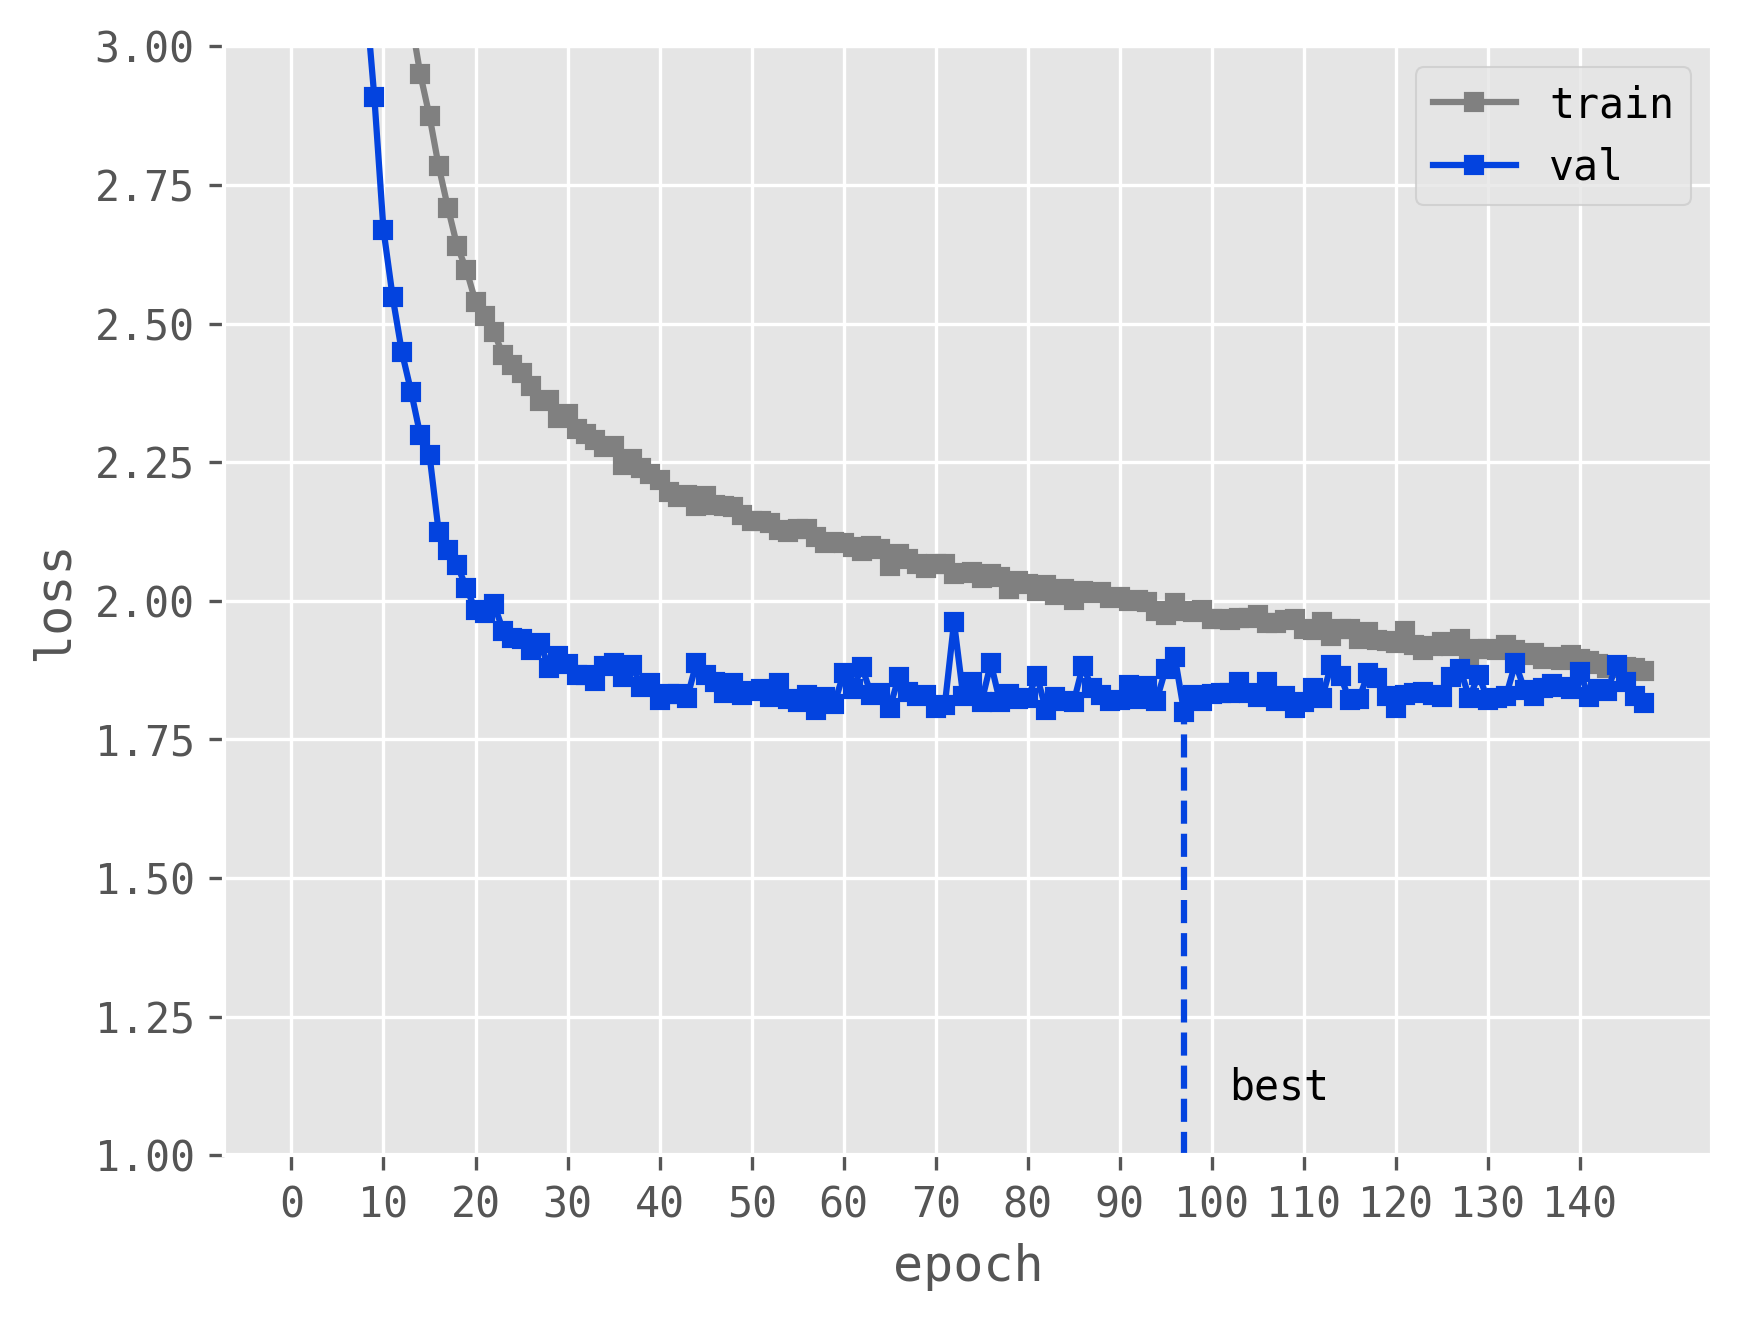

In [28]:
plot_learning_curve(f'./Architectures/{exp_name}')

#### Get Predictions

Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt


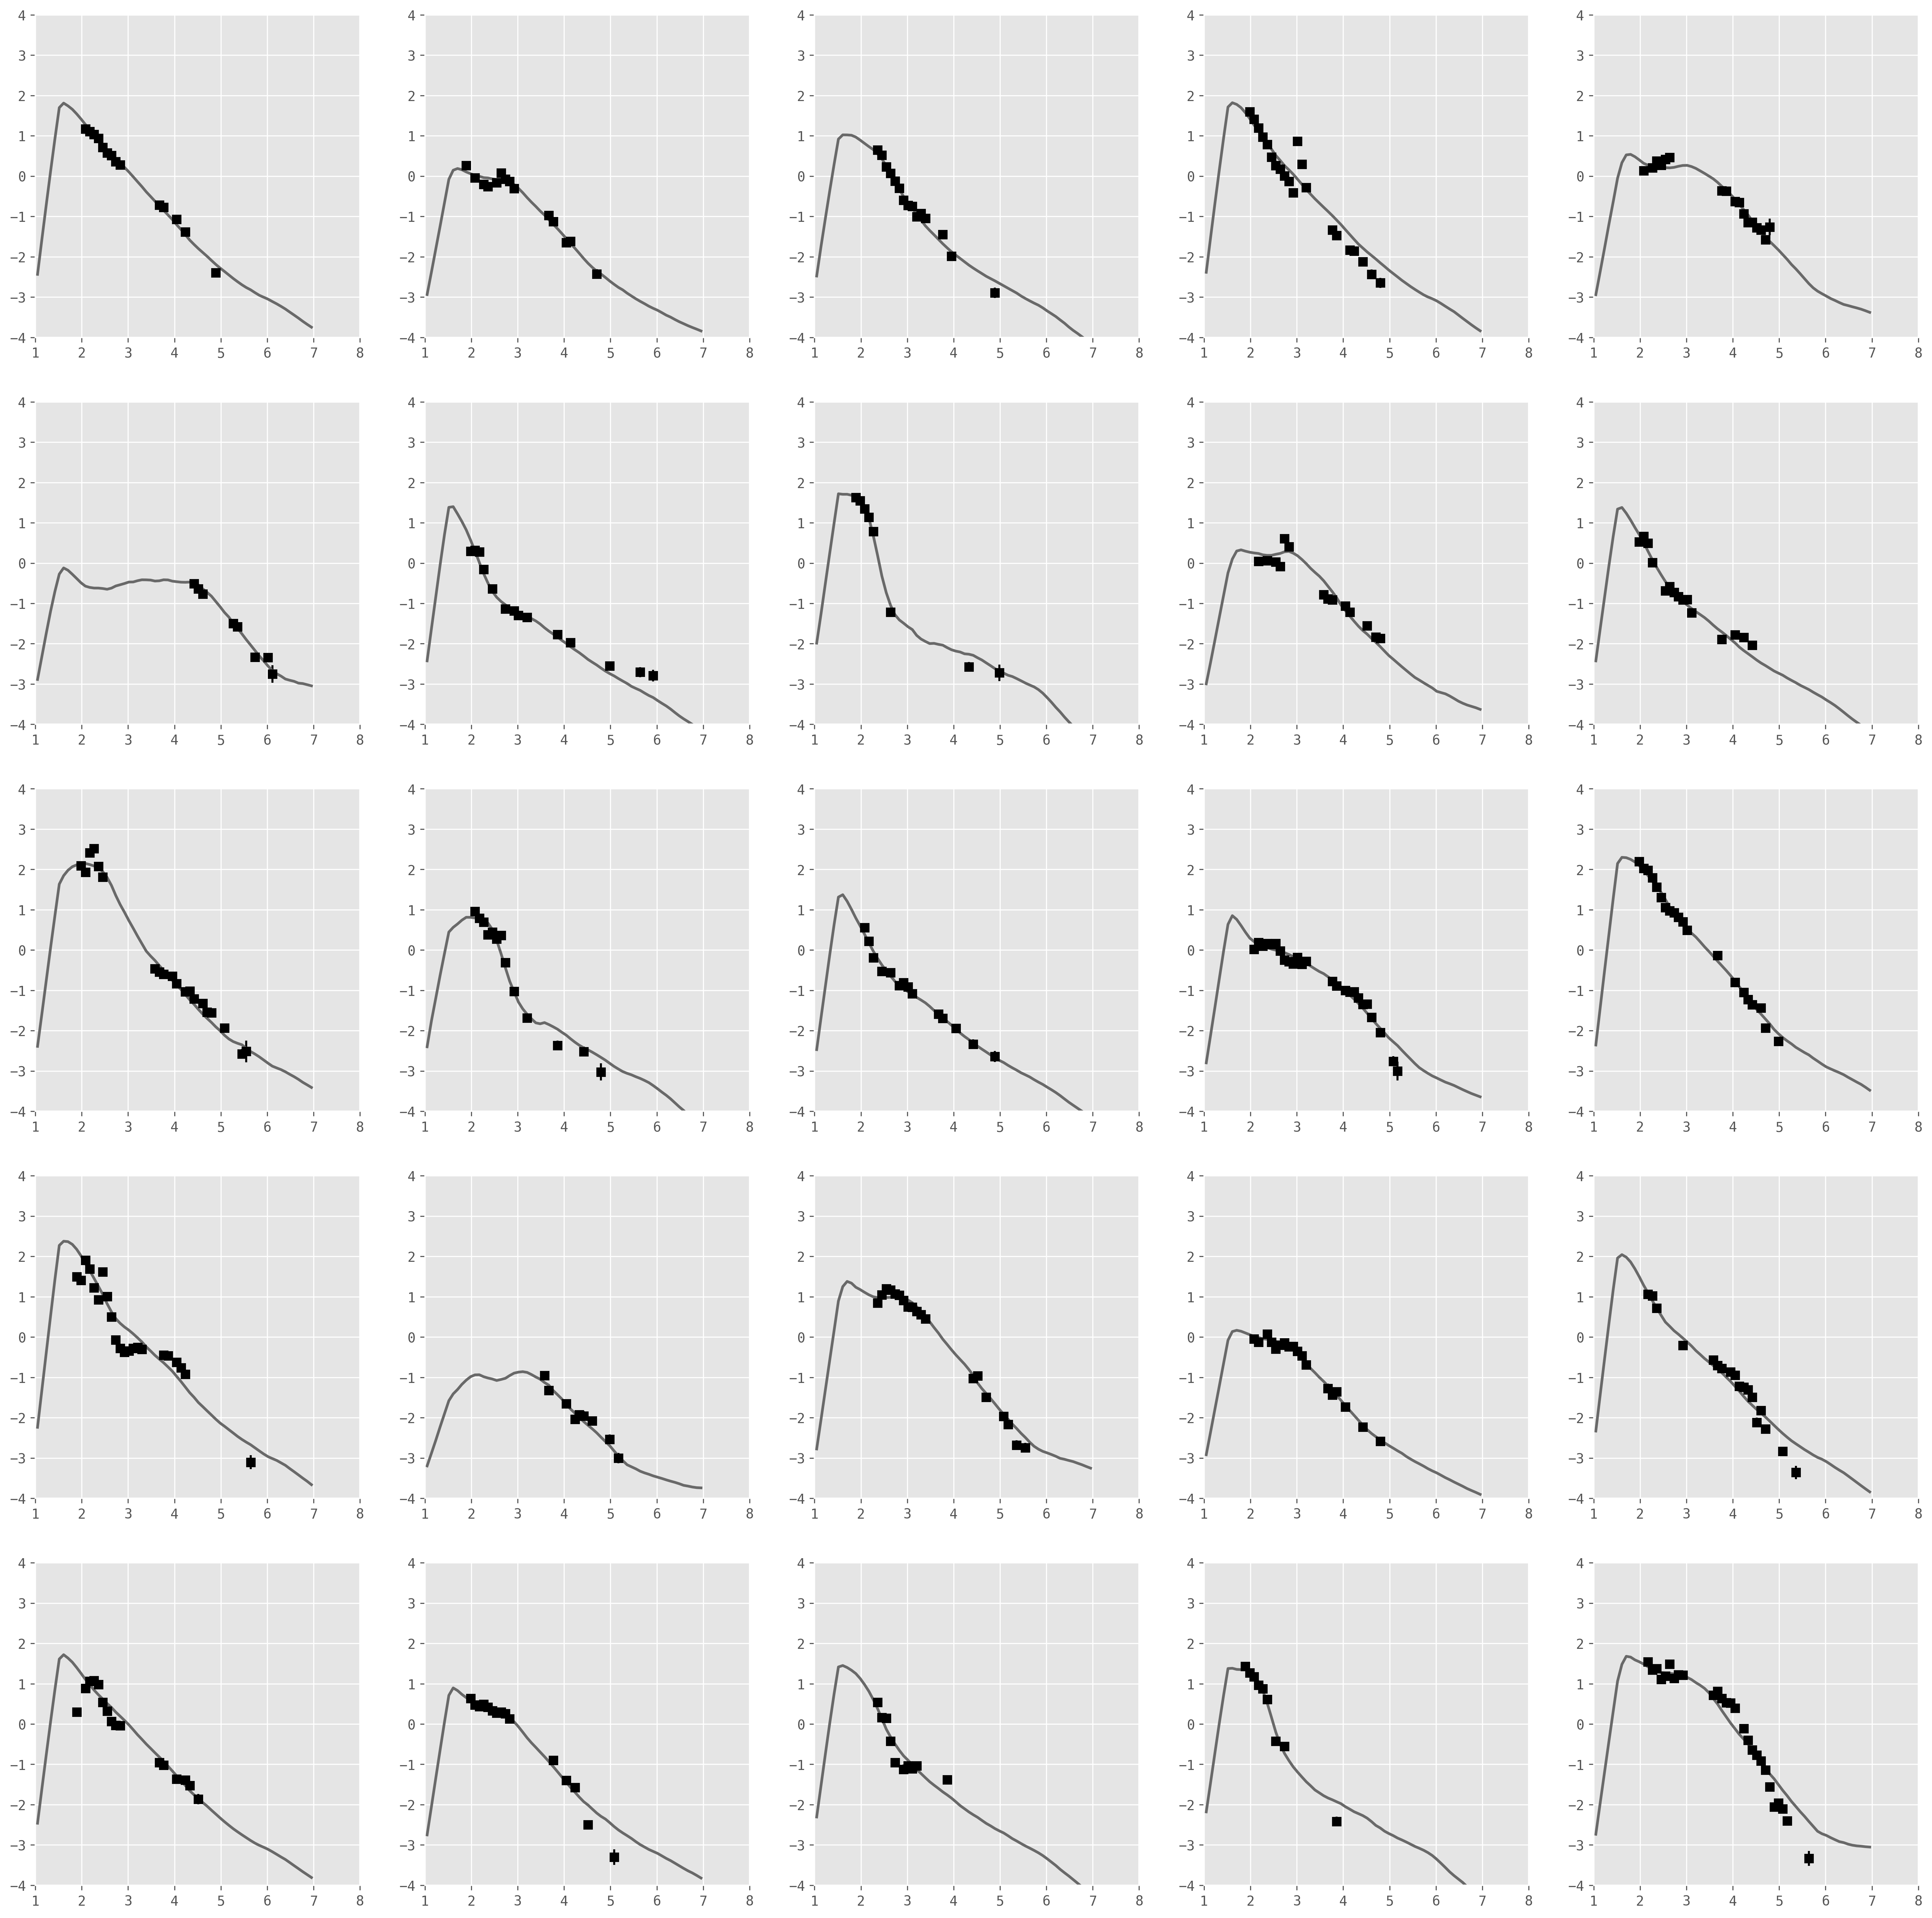

Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_4_copy/best.ckpt


['./Architectures/AE_dim=3_archi=32_4_copy/scoring.joblib']

In [33]:
scoring, df = get_predictions(trainer, autoencoder)
df.to_csv(f'./Architectures/{exp_name}/predictions.csv')
joblib.dump(scoring, f'./Architectures/{exp_name}/scoring.joblib')

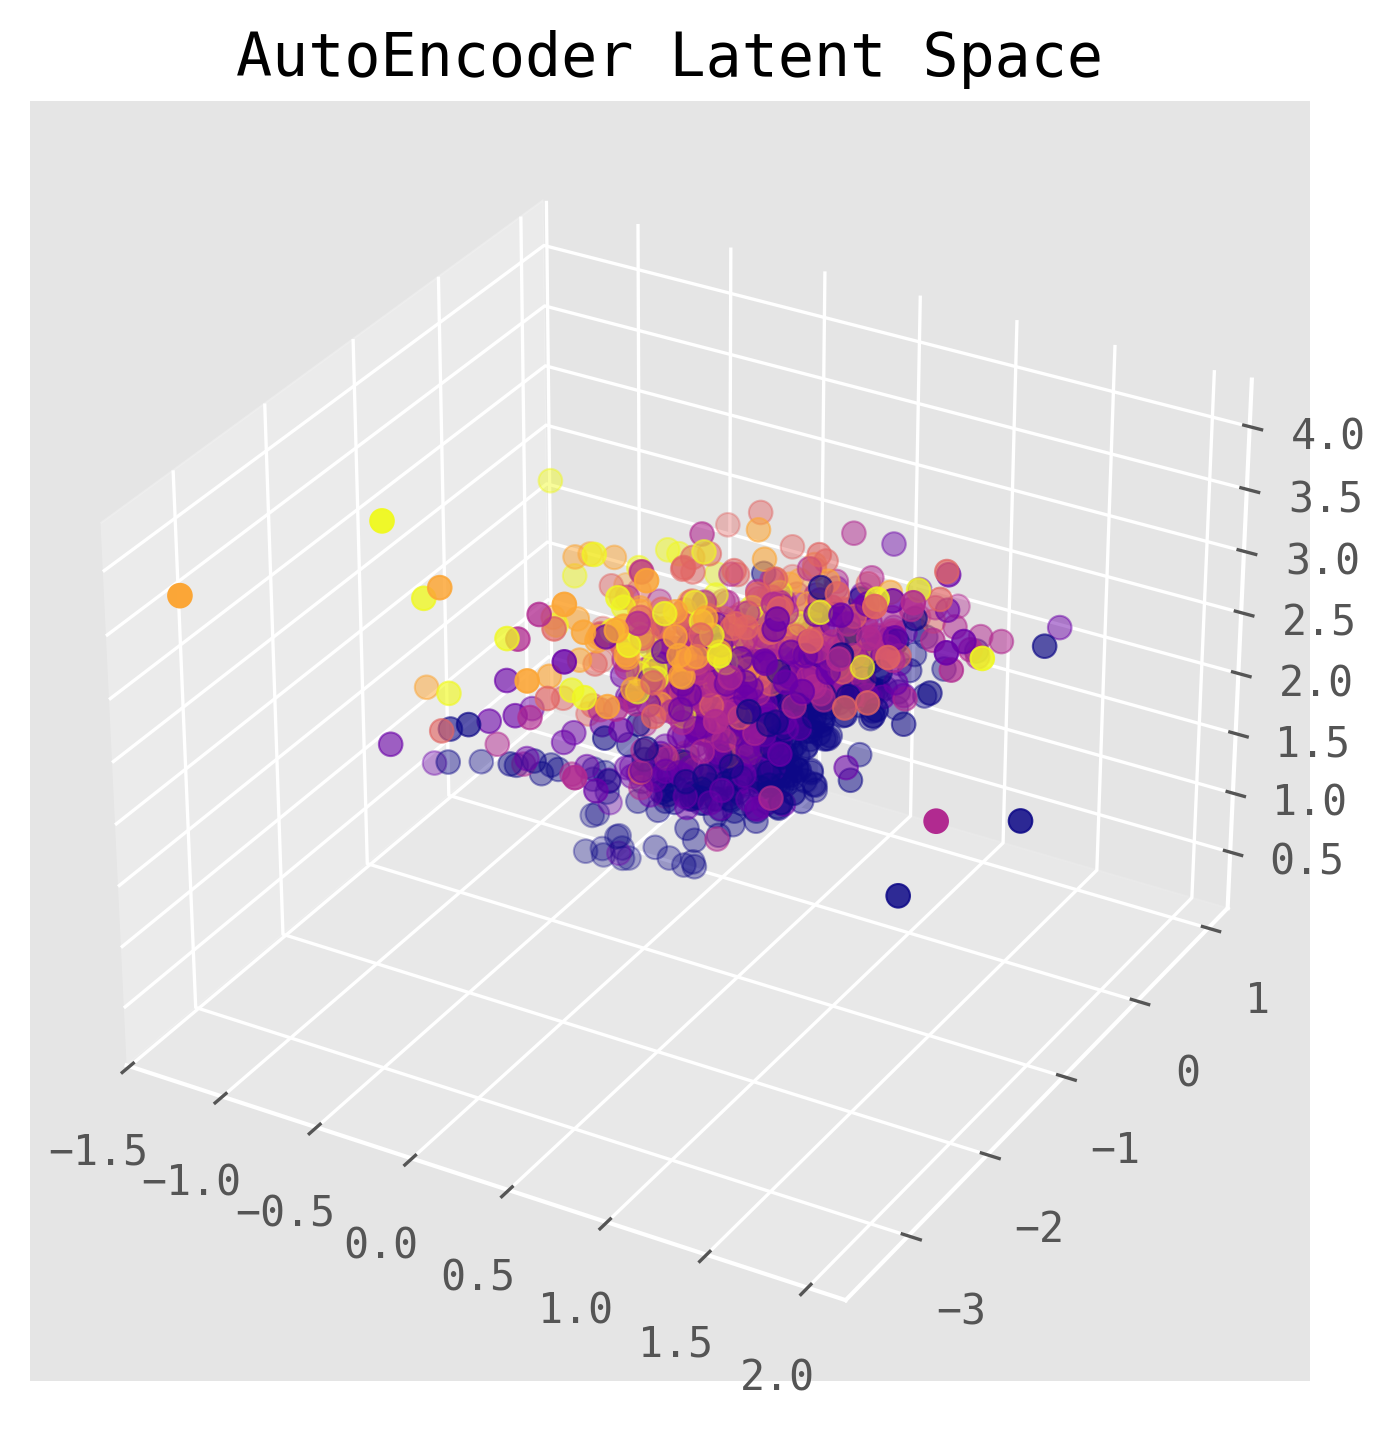

In [34]:
df = pd.concat((df, labels), axis=1, ignore_index=False)
visualize_latent(df,
                 title='AutoEncoder Latent Space',
                 savedir=f'./Architectures/{exp_name}/Figures',
                 show=True)

In [35]:
print('ROC-AUC Score:'+
      '\n    train : '+
      str(round(roc_auc_score(df.loc[train.index, 'FlaresFlag'].values,
                              -df.loc[train.index, 'score'].values), 2))+
      '\n    val   : '+
      str(round(roc_auc_score(df.loc[val.index, 'FlaresFlag'].values,
                              -df.loc[val.index, 'score'].values), 2))+
      '\n    test  : '+
      str(round(roc_auc_score(df.loc[test.index, 'FlaresFlag'].values,
                              -df.loc[test.index, 'score'].values), 2))
     )

ROC-AUC Score:
    train : 0.87
    val   : 0.85
    test  : 0.89


In [36]:
scaler, LinReg = explorer(df)

correlation between latent features and numbreaks:  [-0.176 -0.242  0.63 ]
Linear Regression CoD score
for numbreaks prediction problem
using latent features as X:
    train : 0.5064340506321761
    val   : 0.5066114541792257
    test  : 0.4578128980783227


In [37]:
df[df['p-value']<=0.01].sort_values(by='score', axis=0)

,feature_0,feature_1,feature_2,wMSE,pred_error,sample,score,p-value,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 221009A,-1.280481,-3.446096,3.739030,140.920638,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-36.043653,2.220446e-16,4,Canonical,0.5400,0.151,"[(55599.99999999999, 73100.0), (73500.0, 89400...",1
GRB 200122A,0.208152,-0.581452,2.571024,59.646251,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-7.632271,4.845594e-04,1,One-break,0.0154,NaN,"[(90.7, 355)]",1
GRB 100727A,0.272868,-0.031423,2.071202,44.468105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.72...",test,-6.650889,1.292872e-03,2,Canonical,0.0607,NaN,"[(136, 597)]",1
GRB 170531B,0.588692,-0.252299,2.309325,40.431046,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-6.425460,1.619789e-03,0,No breaks,0.1400,2.366,"[(135, 276), (540, 880)]",1
GRB 130528A,0.025999,-0.591666,2.106342,37.340711,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.632...",test,-6.119162,2.200299e-03,3,Canonical,0.0926,NaN,"[(543, 1452)]",1
GRB 131103A,0.209139,-0.644002,1.942924,33.257761,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",val,-5.459398,4.256119e-03,3,Canonical,0.0114,0.599,"[(400, 600), (630, 1000)]",1
GRB 180329B,0.571650,-0.297737,2.431561,31.349830,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-5.103294,6.076699e-03,2,Canonical,0.0253,1.998,"[(135, 432)]",1
GRB 121027A,-0.351594,-1.324246,2.319823,30.022843,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.866305,7.701769e-03,4,Canonical,0.0159,1.773,"[(141, 194), (219, 520), (1070, 33800.0)]",1
GRB 100619A,0.005498,-0.303684,2.259261,29.336074,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.750288,8.649205e-03,2,Canonical,0.0219,NaN,"[(72.6, 128), (870, 5397)]",1
GRB 080503,1.049407,0.407824,2.371072,29.082750,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-4.708764,9.015911e-03,2,Oddball,0.0699,NaN,[],0


## *«Purblind»* Architecture (16, 4)

Reduced number of channels

In [32]:
encoder, decoder, autoencoder, exp_name = create_models(
    latent_dim=3, architecture=(16, 4))

#### Training Loop

In [33]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/{exp_name} --port 6013

In [34]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', mode='min', min_delta=0, patience=20)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'./lightning_logs/{exp_name}',
    filename='best', monitor='val_loss', mode='min')

logger = TensorBoardLogger(save_dir='./lightning_logs', name=exp_name)

trainer = L.Trainer(max_epochs=500, logger=logger,
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    enable_progress_bar=False
                   )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(autoencoder, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 34.6 K | train
1 | decoder | Decoder | 35.2 K | train
--------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69.8 K    Total params
0.279     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


In [36]:
save_latest_model(exp_name, f'./Architectures/{exp_name}')

model logged at ./Architectures/AE_dim=3_archi=16_4


Found 1 file(s)
Processing events.out.tfevents.1732394684.MacBook-Air-Nickolay.local.42709.1


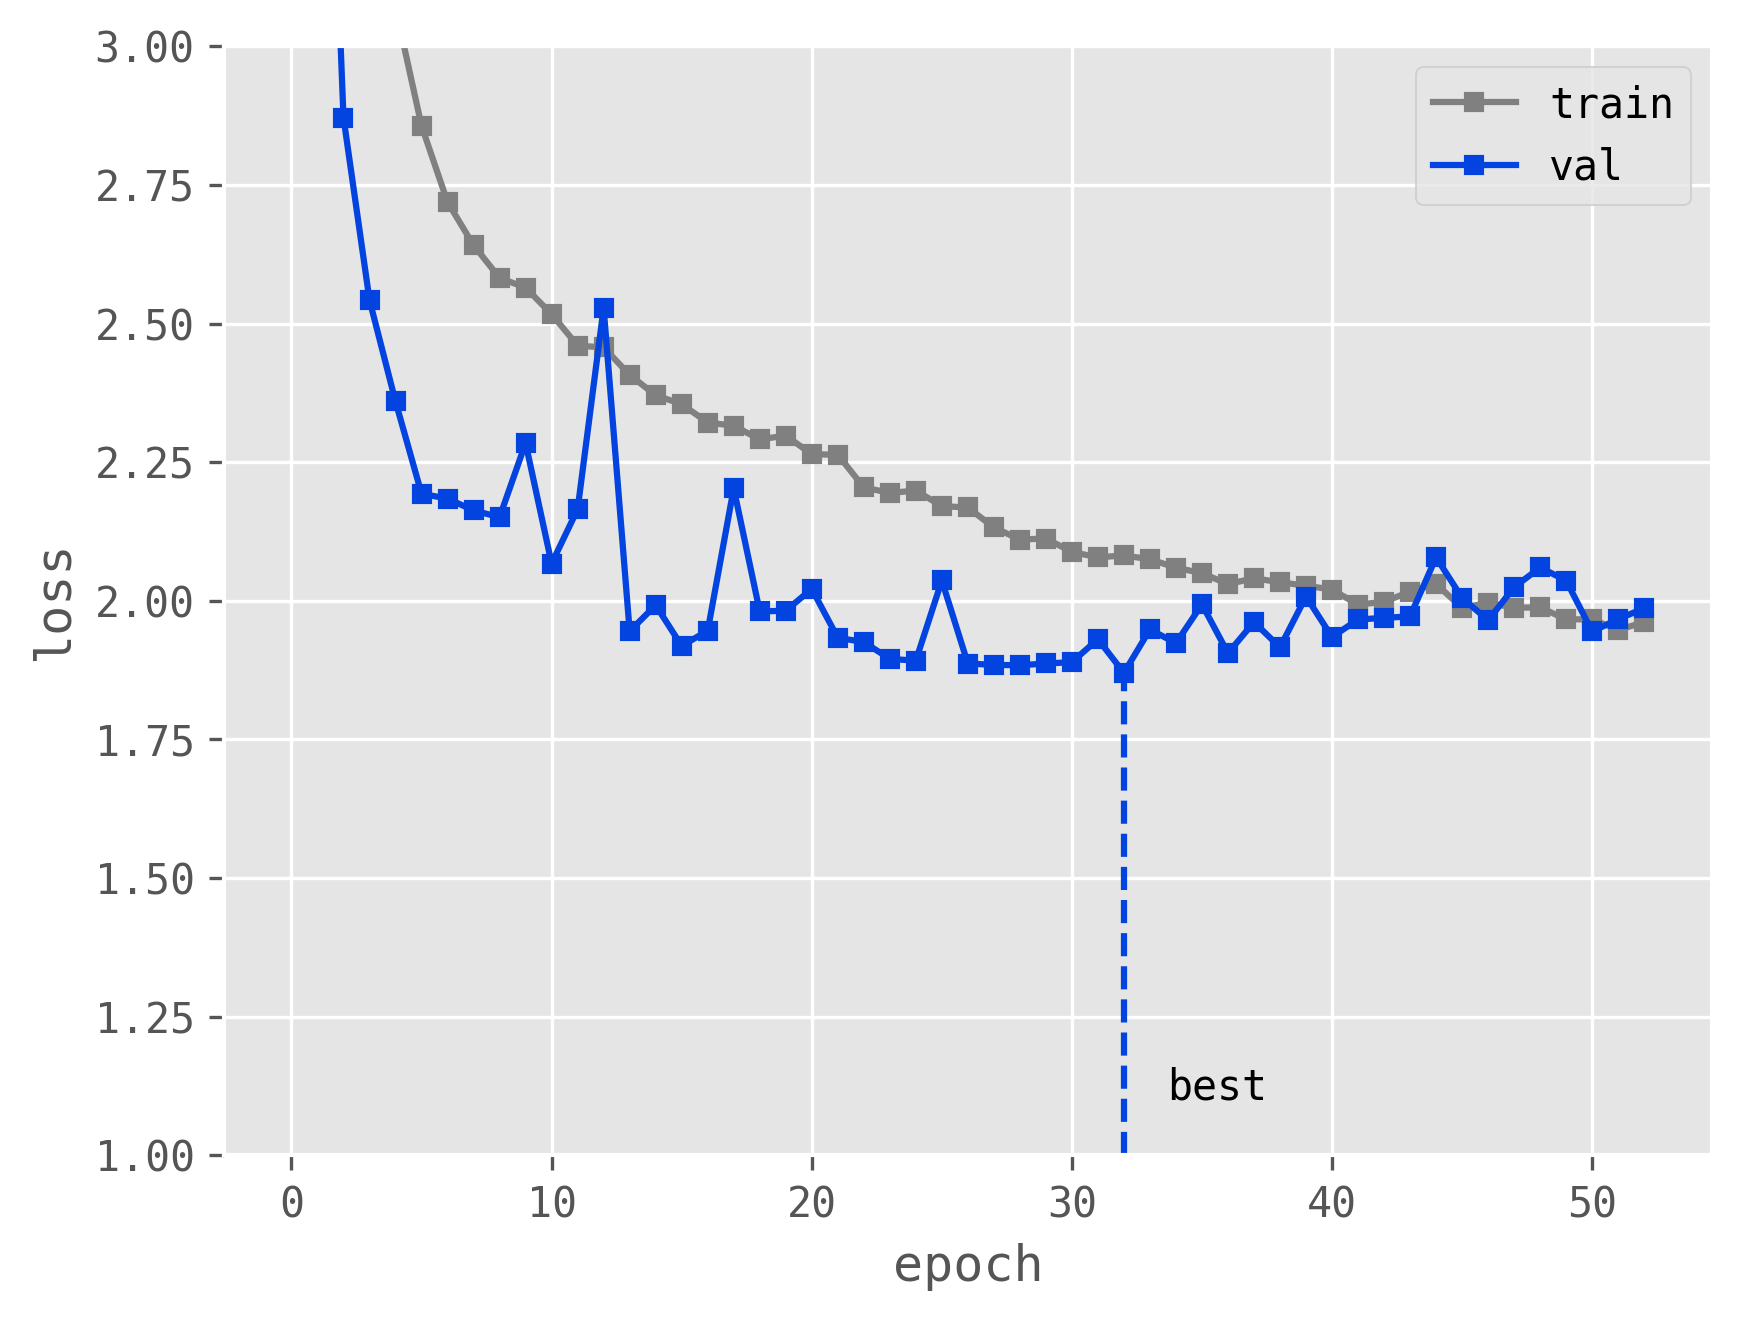

In [37]:
plot_learning_curve(f'./Architectures/{exp_name}')

#### Get Predictions

In [38]:
scoring, df = get_predictions(trainer, autoencoder)
df.to_csv(f'./Architectures/{exp_name}/predictions.csv')
joblib.dump(scoring, f'./Architectures/{exp_name}/scoring.joblib')

Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_4/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GR

['./Architectures/AE_dim=3_archi=16_4/scoring.joblib']

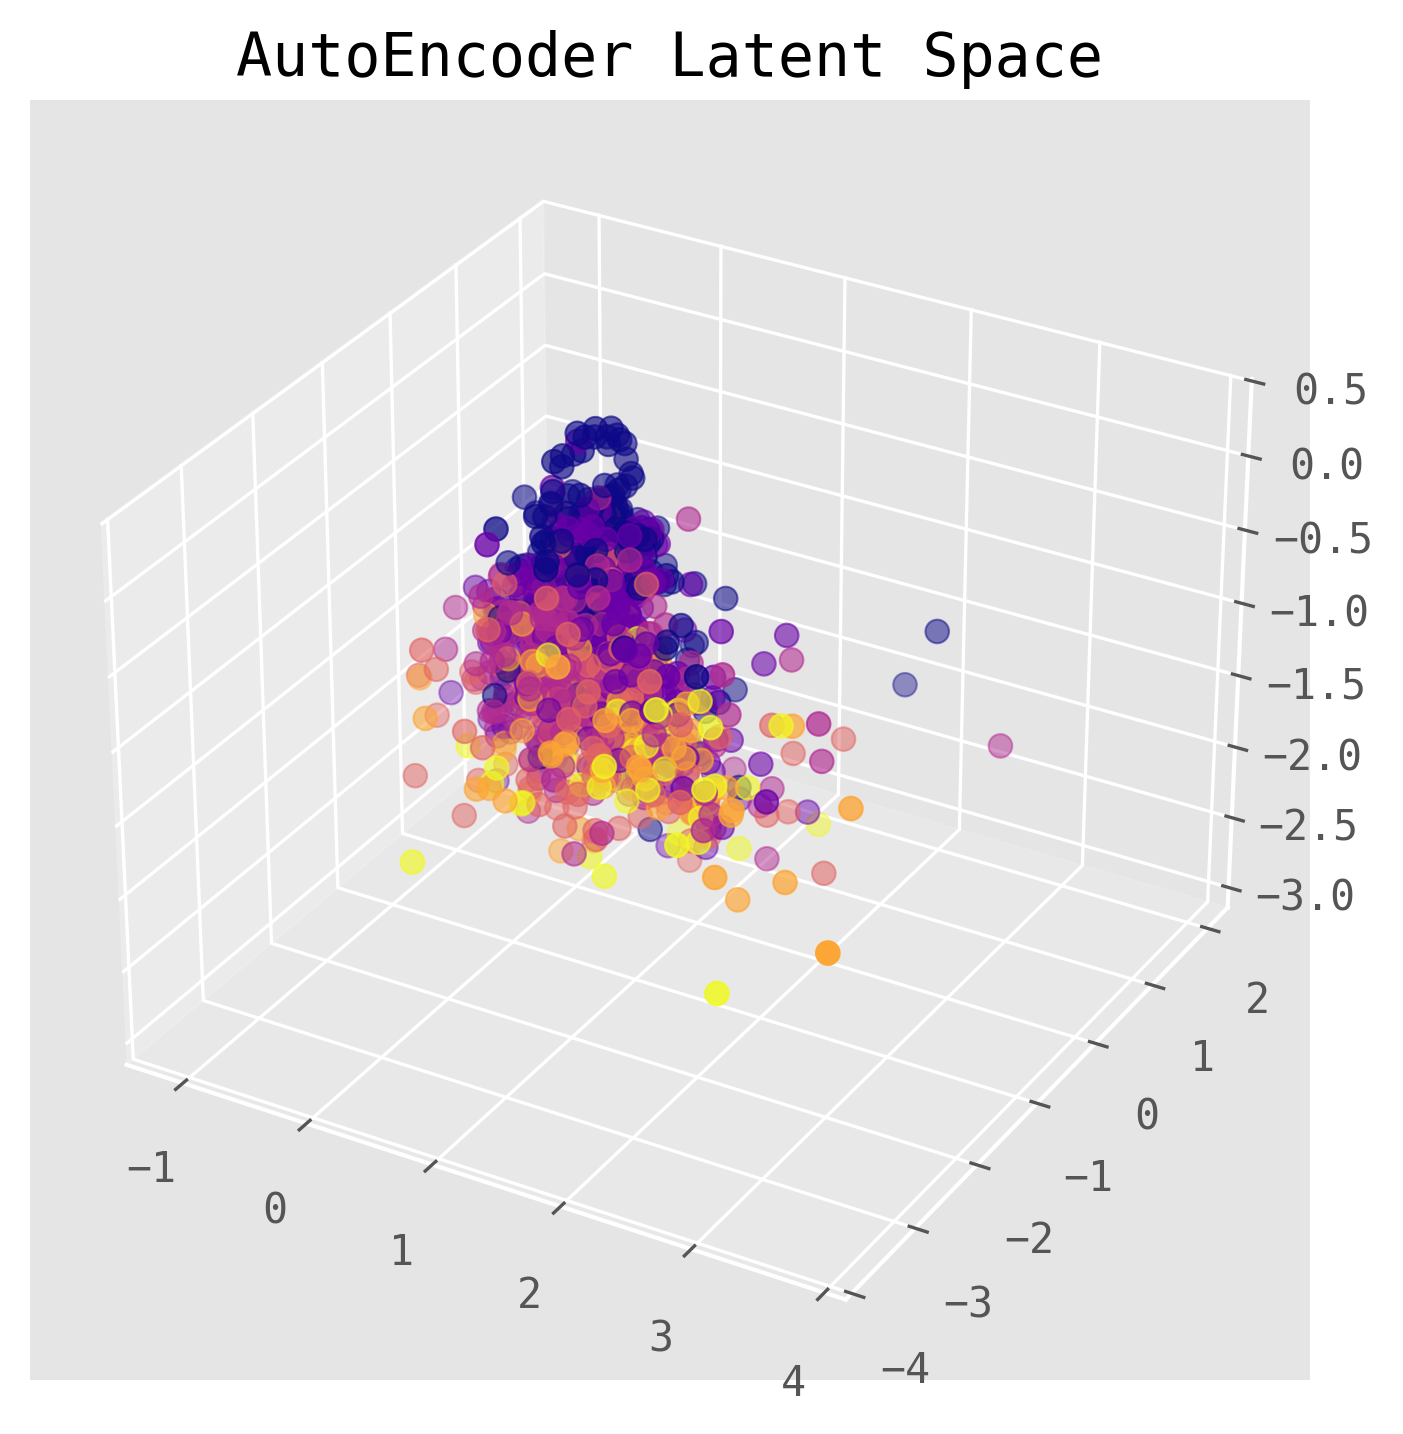

In [39]:
df = pd.concat((df, labels), axis=1, ignore_index=False)
visualize_latent(df,
                 title='AutoEncoder Latent Space',
                 savedir=f'./Architectures/{exp_name}/Figures',
                 show=True)

In [40]:
print('ROC-AUC Score:'+
      '\n    train : '+
      str(round(roc_auc_score(df.loc[train.index, 'FlaresFlag'].values,
                              -df.loc[train.index, 'score'].values), 2))+
      '\n    val   : '+
      str(round(roc_auc_score(df.loc[val.index, 'FlaresFlag'].values,
                              -df.loc[val.index, 'score'].values), 2))+
      '\n    test  : '+
      str(round(roc_auc_score(df.loc[test.index, 'FlaresFlag'].values,
                              -df.loc[test.index, 'score'].values), 2))
     )

ROC-AUC Score:
    train : 0.87
    val   : 0.85
    test  : 0.89


In [41]:
scaler, LinReg = explorer(df)

correlation between latent features and numbreaks:  [ 0.324 -0.514 -0.409]
Linear Regression CoD score
for numbreaks prediction problem
using latent features as X:
    train : 0.5027309873933347
    val   : 0.5090517780855645
    test  : 0.45494285412836


In [42]:
df[df['p-value']<=0.01].sort_values(by='score', axis=0)

,feature_0,feature_1,feature_2,wMSE,pred_error,sample,score,p-value,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 200122A,0.868100,-0.981735,-1.648438,62.651634,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-7.762490,0.000425,1,One-break,0.0154,NaN,"[(90.7, 355)]",1
GRB 170531B,0.444955,0.053151,-2.061251,42.030899,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-6.329484,0.001783,0,No breaks,0.1400,2.366,"[(135, 276), (540, 880)]",1
GRB 130528A,0.806915,-0.670108,-1.332535,41.250648,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.651...",test,-6.260133,0.001911,3,Canonical,0.0926,NaN,"[(543, 1452)]",1
GRB 100727A,0.066581,-0.297586,-1.555412,39.073848,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.996...",test,-6.030783,0.002404,2,Canonical,0.0607,NaN,"[(136, 597)]",1
GRB 181110A,0.269888,-0.748480,-2.525398,37.342546,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.087...",val,-5.810003,0.002997,4,Canonical,0.0766,1.505,"[(650, 3000)]",1
GRB 191031C,1.489823,-0.730857,-1.017872,34.673166,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.417261,0.004439,1,One-break,0.1800,NaN,"[(272, 459), (707, 162000.0)]",1
GRB 131103A,0.873375,-0.333462,-1.112393,34.342654,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",val,-5.366200,0.004672,3,Canonical,0.0114,0.599,"[(400, 600), (630, 1000)]",1
GRB 100619A,0.360615,-0.789720,-1.581794,31.474957,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.929877,0.007227,2,Canonical,0.0219,NaN,"[(72.6, 128), (870, 5397)]",1
GRB 121027A,1.304441,-1.638616,-1.016973,31.431242,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.923498,0.007274,4,Canonical,0.0159,1.773,"[(141, 194), (219, 520), (1070, 33800.0)]",1


## *«Shallow»* Architecture (32, 2)

Reduced depth

In [43]:
encoder, decoder, autoencoder, exp_name = create_models(
    latent_dim=3, architecture=(32, 2))

#### Training Loop

In [44]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/{exp_name} --port 6015

In [45]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', mode='min', min_delta=0, patience=20)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'./lightning_logs/{exp_name}',
    filename='best', monitor='val_loss', mode='min')

logger = TensorBoardLogger(save_dir='./lightning_logs', name=exp_name)

trainer = L.Trainer(max_epochs=500, logger=logger,
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    enable_progress_bar=False
                   )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(autoencoder, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 9.6 K  | train
1 | decoder | Decoder | 8.4 K  | train
--------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


In [47]:
save_latest_model(exp_name, f'./Architectures/{exp_name}')

model logged at ./Architectures/AE_dim=3_archi=32_2


Found 1 file(s)
Processing events.out.tfevents.1732395260.MacBook-Air-Nickolay.local.42709.2


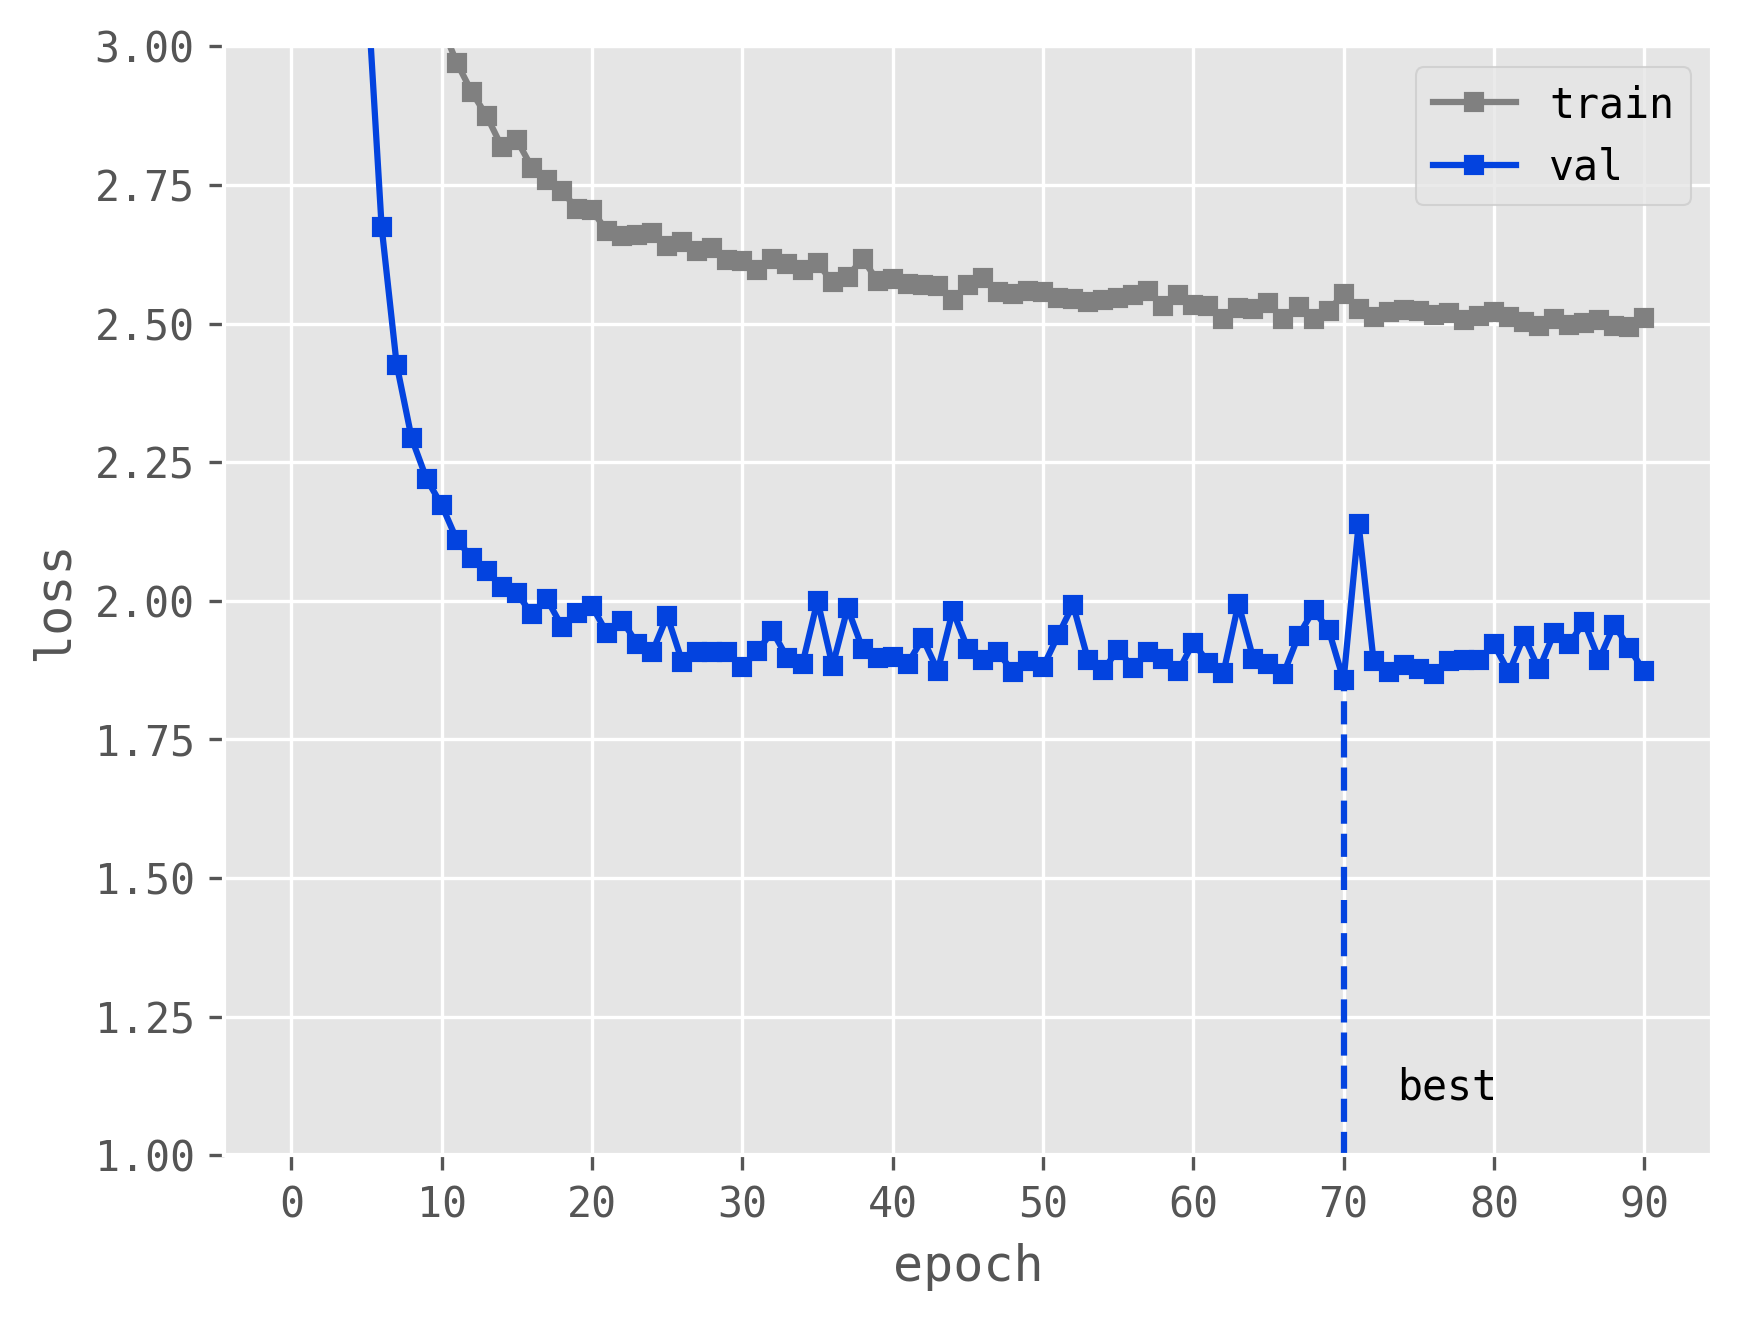

In [48]:
plot_learning_curve(f'./Architectures/{exp_name}')

#### Get Predictions

In [49]:
scoring, df = get_predictions(trainer, autoencoder)
df.to_csv(f'./Architectures/{exp_name}/predictions.csv')
joblib.dump(scoring, f'./Architectures/{exp_name}/scoring.joblib')

Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=32_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GR

['./Architectures/AE_dim=3_archi=32_2/scoring.joblib']

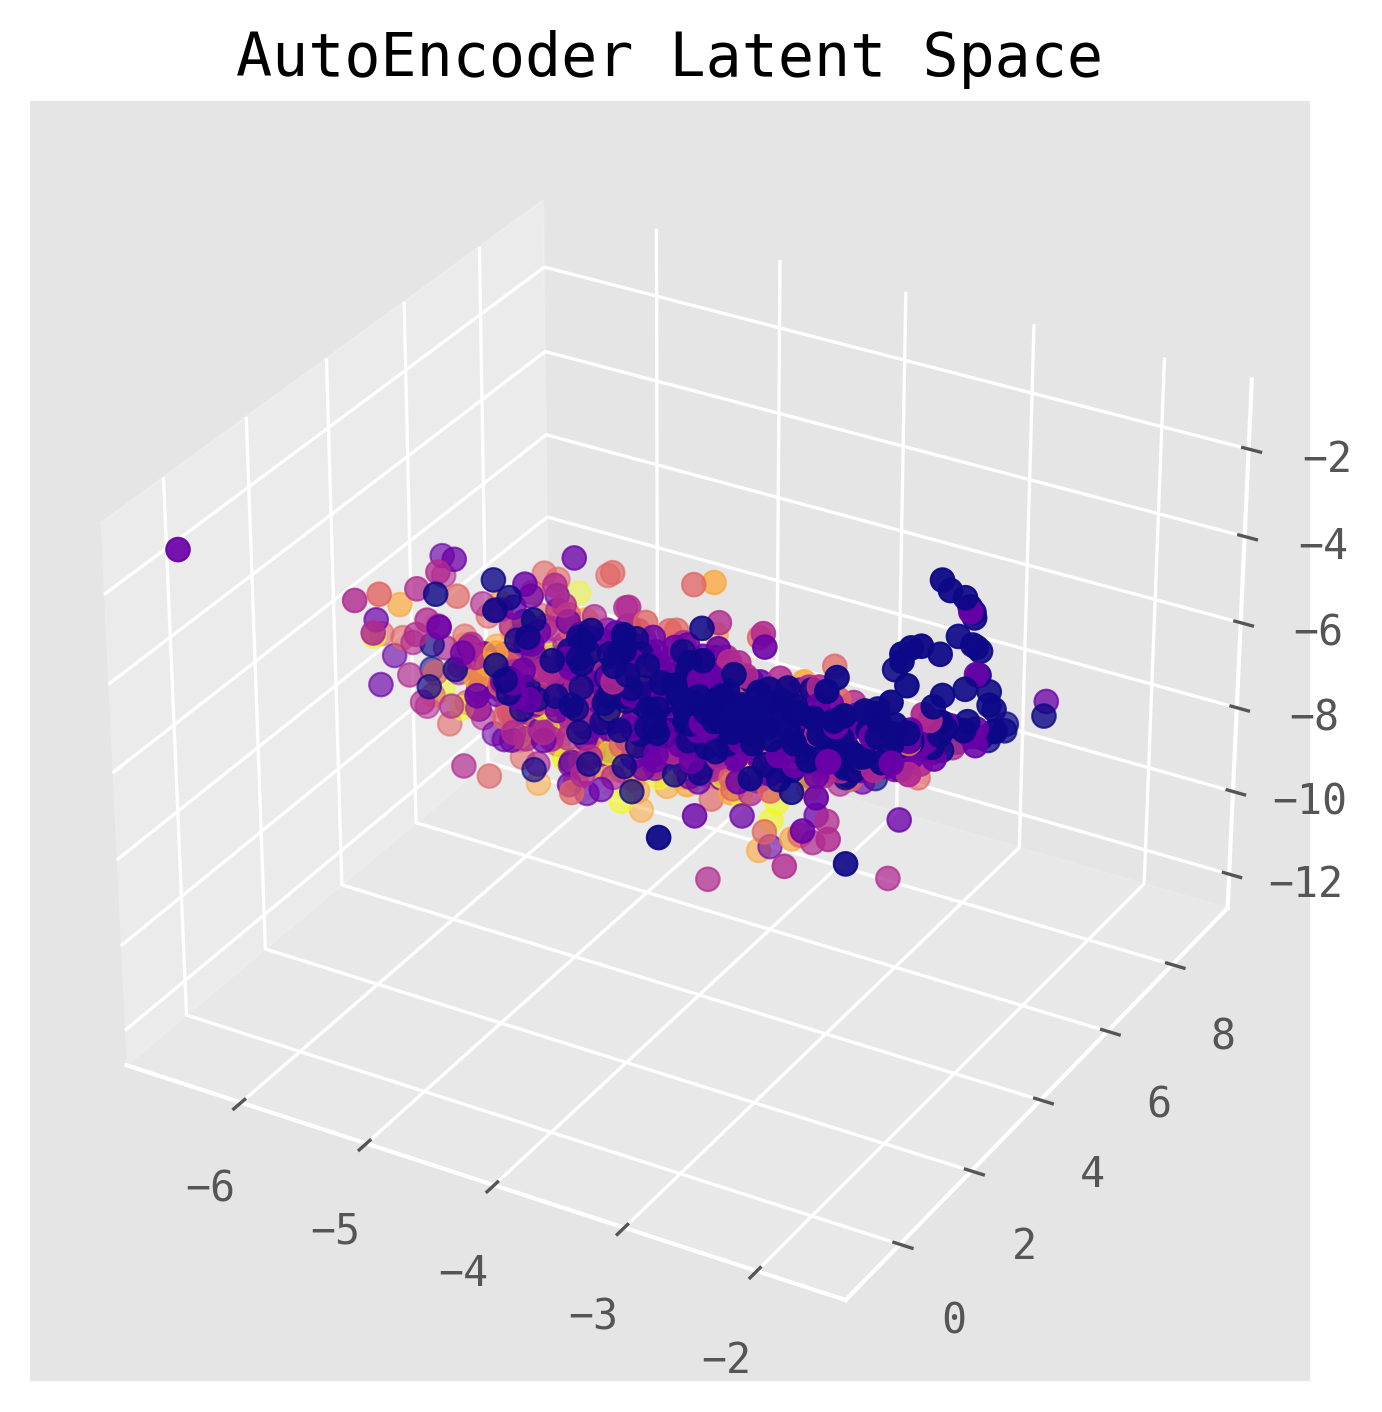

In [50]:
df = pd.concat((df, labels), axis=1, ignore_index=False)
visualize_latent(df,
                 title='AutoEncoder Latent Space',
                 savedir=f'./Architectures/{exp_name}/Figures',
                 show=True)

In [51]:
print('ROC-AUC Score:'+
      '\n    train : '+
      str(round(roc_auc_score(df.loc[train.index, 'FlaresFlag'].values,
                              -df.loc[train.index, 'score'].values), 2))+
      '\n    val   : '+
      str(round(roc_auc_score(df.loc[val.index, 'FlaresFlag'].values,
                              -df.loc[val.index, 'score'].values), 2))+
      '\n    test  : '+
      str(round(roc_auc_score(df.loc[test.index, 'FlaresFlag'].values,
                              -df.loc[test.index, 'score'].values), 2))
     )

ROC-AUC Score:
    train : 0.86
    val   : 0.86
    test  : 0.88


In [52]:
scaler, LinReg = explorer(df)

correlation between latent features and numbreaks:  [-0.457  0.574 -0.574]
Linear Regression CoD score
for numbreaks prediction problem
using latent features as X:
    train : 0.4918070049634149
    val   : 0.49402401176567823
    test  : 0.4268656539895195


In [53]:
df[df['p-value']<=0.01].sort_values(by='score', axis=0)

,feature_0,feature_1,feature_2,wMSE,pred_error,sample,score,p-value,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 221009A,-4.765068,9.037171,-12.039139,112.645020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-21.046257,7.239805e-10,4,Canonical,0.5400,0.151,"[(55599.99999999999, 73100.0), (73500.0, 89400...",1
GRB 200509A,-2.952049,2.613963,-7.742818,60.052970,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-6.006186,2.463466e-03,2,Canonical,0.1600,NaN,"[(262, 1332)]",1
GRB 110820A,-5.004367,2.362570,-5.041775,56.420747,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.572690,3.800243e-03,0,No breaks,0.4800,NaN,"[(163, 475)]",1
GRB 200122A,-4.874622,4.215540,-7.314177,55.584828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.485242,4.147530e-03,1,One-break,0.0154,NaN,"[(90.7, 355)]",1
GRB 060526,-4.465729,2.663533,-6.599580,54.263496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.356229,4.718666e-03,2,Canonical,0.0632,3.210,"[(205, 1089)]",1
GRB 130528A,-3.363406,3.745856,-6.739322,51.468291,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.25...",test,-5.117231,5.992593e-03,3,Canonical,0.0926,NaN,"[(543, 1452)]",1
GRB 060929,-3.323183,0.560438,-5.841499,48.140371,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.878053,7.611817e-03,0,No breaks,0.0421,NaN,"[(205, 1049)]",1
GRB 191031C,-3.077875,3.945209,-7.696375,45.809387,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.725472,8.866529e-03,1,One-break,0.1800,NaN,"[(272, 459), (707, 162000.0)]",1
GRB 111209A,-3.868775,5.192471,-10.175180,45.490299,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-4.704839,9.051372e-03,4,Canonical,0.0154,0.677,"[(565, 655), (659, 898), (1208, 1675), (1680, ...",1
GRB 201026A,-6.210008,3.292453,-6.184288,45.312455,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.693334,9.156112e-03,1,One-break,0.1100,NaN,"[(133, 519)]",1


## *«Tiny»* Architecture (16, 2)

Reduced both number of channels & depth

In [54]:
encoder, decoder, autoencoder, exp_name = create_models(
    latent_dim=3, architecture=(16, 2))

#### Training loop

In [55]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/{exp_name} --port 6017

In [56]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', mode='min', min_delta=0, patience=20)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'./lightning_logs/{exp_name}',
    filename='best', monitor='val_loss', mode='min')

logger = TensorBoardLogger(save_dir='./lightning_logs', name=exp_name)

trainer = L.Trainer(max_epochs=500, logger=logger,
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    enable_progress_bar=False
                   )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(autoencoder, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 3.3 K  | train
1 | decoder | Decoder | 4.2 K  | train
--------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
0.030     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


In [58]:
save_latest_model(exp_name, f'./Architectures/{exp_name}')

model logged at ./Architectures/AE_dim=3_archi=16_2


Found 1 file(s)
Processing events.out.tfevents.1732395869.MacBook-Air-Nickolay.local.42709.3


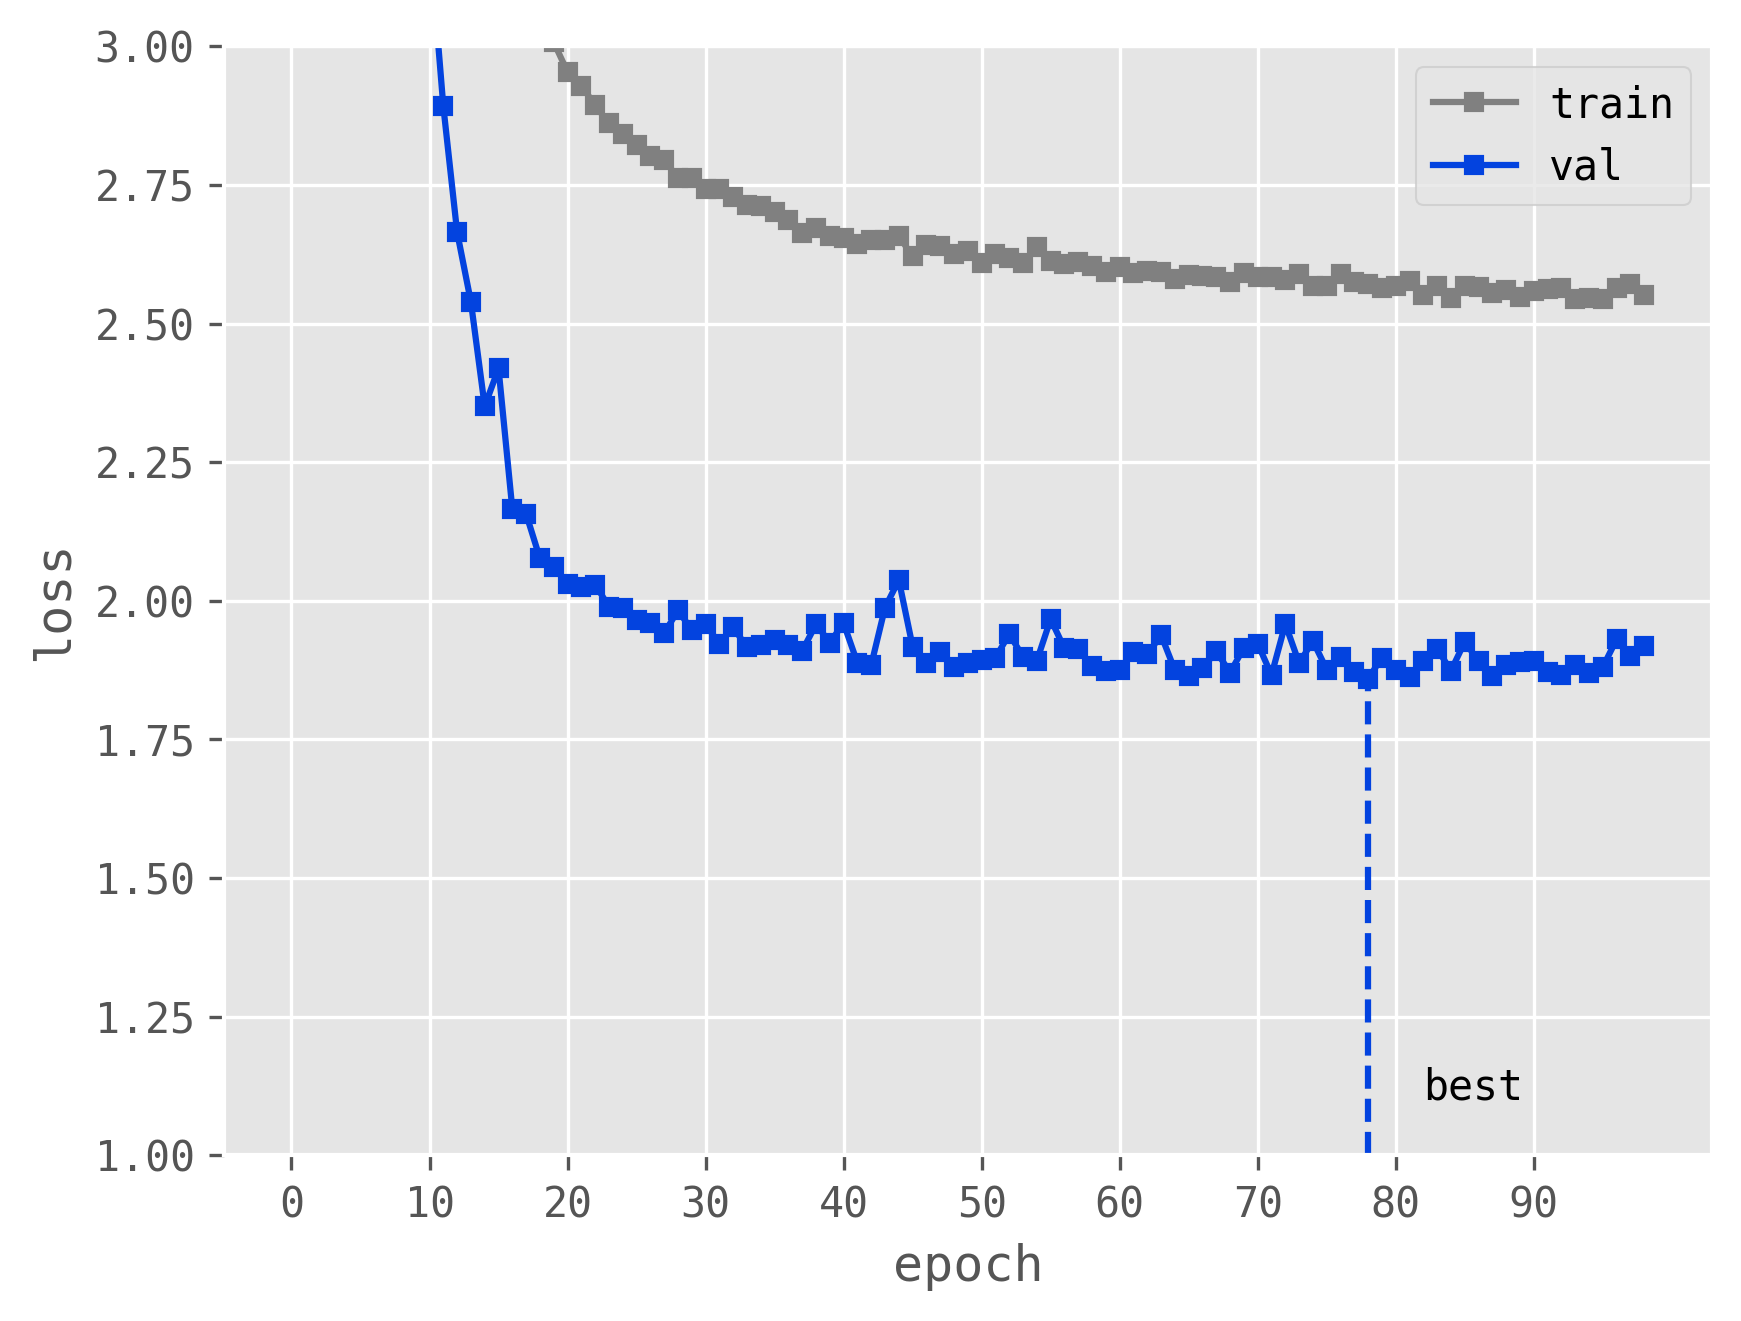

In [59]:
plot_learning_curve(f'./Architectures/{exp_name}')

#### Get Predictions

In [60]:
scoring, df = get_predictions(trainer, autoencoder)
df.to_csv(f'./Architectures/{exp_name}/predictions.csv')

joblib.dump(scoring, f'./Architectures/{exp_name}/scoring.joblib')

Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Loaded model weights from the checkpoint at /Users/nickolaymartynenko/GRB-X-Ray-Afterglow/models/AutoEncoder/lightning_logs/AE_dim=3_archi=16_2/best.ckpt
Restoring states from the checkpoint path at /Users/nickolaymartynenko/GR

['./Architectures/AE_dim=3_archi=16_2/scoring.joblib']

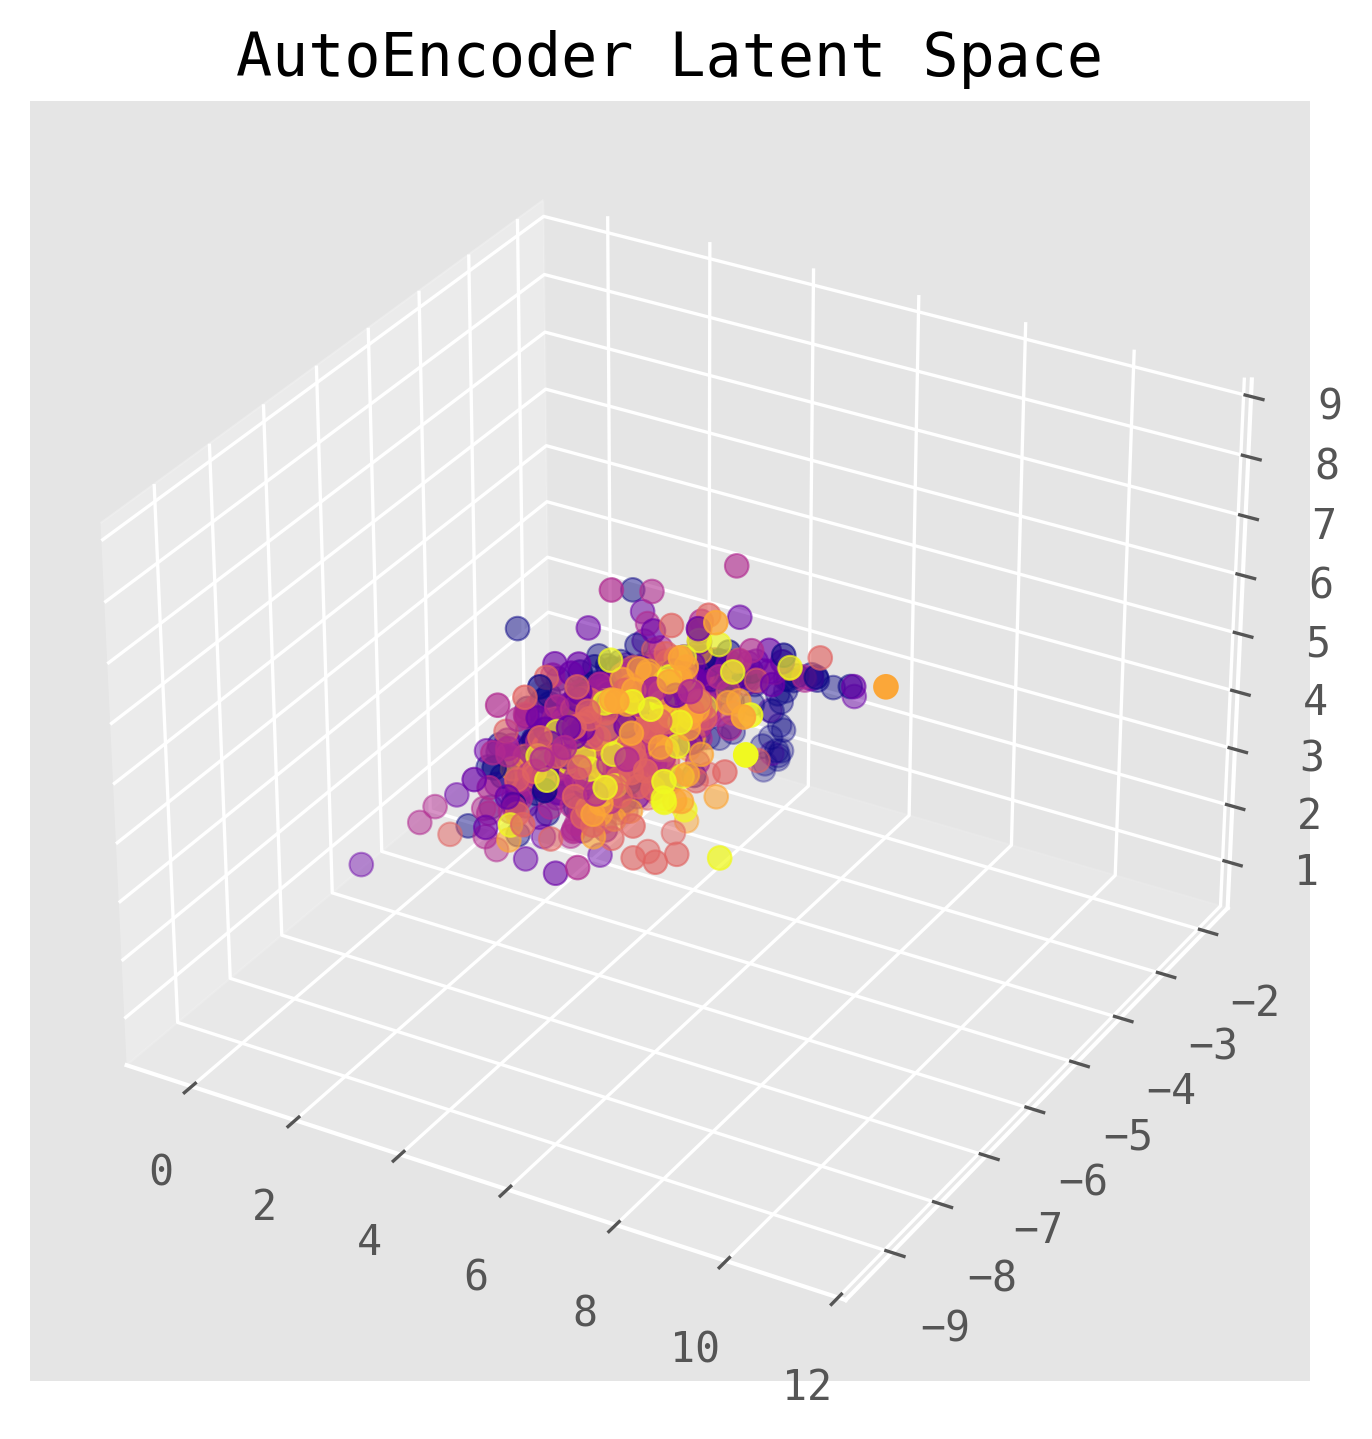

In [61]:
df = pd.concat((df, labels), axis=1, ignore_index=False)
visualize_latent(df,
                 title='AutoEncoder Latent Space',
                 savedir=f'./Architectures/{exp_name}/Figures',
                 show=True)

In [62]:
print('ROC-AUC Score:'+
      '\n    train : '+
      str(round(roc_auc_score(df.loc[train.index, 'FlaresFlag'].values,
                              -df.loc[train.index, 'score'].values), 2))+
      '\n    val   : '+
      str(round(roc_auc_score(df.loc[val.index, 'FlaresFlag'].values,
                              -df.loc[val.index, 'score'].values), 2))+
      '\n    test  : '+
      str(round(roc_auc_score(df.loc[test.index, 'FlaresFlag'].values,
                              -df.loc[test.index, 'score'].values), 2))
     )

ROC-AUC Score:
    train : 0.86
    val   : 0.86
    test  : 0.88


In [63]:
scaler, LinReg = explorer(df)

correlation between latent features and numbreaks:  [ 0.604 -0.589  0.521]
Linear Regression CoD score
for numbreaks prediction problem
using latent features as X:
    train : 0.5034658558890495
    val   : 0.5022876197554559
    test  : 0.4441731663438109


In [64]:
df[df['p-value']<=0.01].sort_values(by='score', axis=0)

,feature_0,feature_1,feature_2,wMSE,pred_error,sample,score,p-value,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 221009A,11.280753,-8.310430,8.703090,76.991406,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-8.738319,0.000160,4,Canonical,0.5400,0.151,"[(55599.99999999999, 73100.0), (73500.0, 89400...",1
GRB 110820A,2.875524,-6.025882,3.760373,57.600981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.644663,0.003536,0,No breaks,0.4800,NaN,"[(163, 475)]",1
GRB 130528A,4.826391,-5.139323,5.124507,56.960887,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.83...",test,-5.574764,0.003792,3,Canonical,0.0926,NaN,"[(543, 1452)]",1
GRB 200509A,4.240642,-5.128908,6.263245,54.892008,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.363619,0.004684,2,Canonical,0.1600,NaN,"[(262, 1332)]",1
GRB 200122A,5.343526,-6.850008,5.488217,54.232233,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.300974,0.004987,1,One-break,0.0154,NaN,"[(90.7, 355)]",1
GRB 060526,3.483112,-6.155106,5.083294,53.849451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-5.265644,0.005166,2,Canonical,0.0632,3.210,"[(205, 1089)]",1
GRB 111209A,7.142059,-7.014836,7.771436,50.139390,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",test,-4.958836,0.007021,4,Canonical,0.0154,0.677,"[(565, 655), (659, 898), (1208, 1675), (1680, ...",1
GRB 060929,1.492250,-4.961413,4.824279,49.362920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.901749,0.007434,0,No breaks,0.0421,NaN,"[(205, 1049)]",1
GRB 191031C,5.360180,-5.373313,5.861377,46.978275,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.737347,0.008762,1,One-break,0.1800,NaN,"[(272, 459), (707, 162000.0)]",1
GRB 201026A,3.918921,-7.703266,4.533399,46.084904,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",train,-4.678735,0.009291,1,One-break,0.1100,NaN,"[(133, 519)]",1
